# PIC 16B Final Project
### By:  Artem Kiryukhin and Karl Puttler

For this project we plan to use a dataset of 87,000 images of various American Sign Language hand signs to train a model which could accurately translate the hand signs to their appropriate meanings.
TODO: EXPAND THIS

Below we import the necessary libraries

In [1]:
from tqdm import tqdm
import numpy as np
import torch
# import torch.nn as nn
# from torchvision import transforms, datasets
# from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
# from PIL import Image
# from IPython.display import Image as Img
from sklearn.metrics import confusion_matrix
import seaborn as sns

from dataProcessing import *
from models import *

Since we wanted to work with our trained model and not necessarily train a new one every single time we worked in this file we implemented simple lambda functions to handle saving and loading the model parameters.

In [2]:
# set device to gpu if available and cpu if not
G_DEVICE            = torch.device("cuda") or torch.device("cpu")
G_BATCH_SIZE        = 128
G_NUM_WORKERS       = 16
G_TEST_IMG_PATH     = "ASL_Data/asl_alphabet_test/asl_alphabet_test"
G_TRAIN_IMG_PATH    = "ASL_Data/asl_alphabet_train/asl_alphabet_train"

In [3]:
# save and load model functions
save_model = lambda model, name: torch.save(model.state_dict(), name)
load_model = lambda model, name: model.load_state_dict(torch.load(name))

## LeNet

### Visualizing the Processed Images
The code below loads one batch from the train_loader object we defined in the dataProcessing file of this project. This object is created using the DataLoader class from PyTorch. Thanks to this class we do not need to worry about manually shuffling, batching, and loading the data. In addition to loading a single batch we define a list of label names to display instead of the numerical labels that the data has right now. Finally we itterate through a couple of samples and display the images that we will be inputting into our model. Notice the strange colors, these are due to standardization we performed on the pixel values of the images.

In [4]:
# load data for LeNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

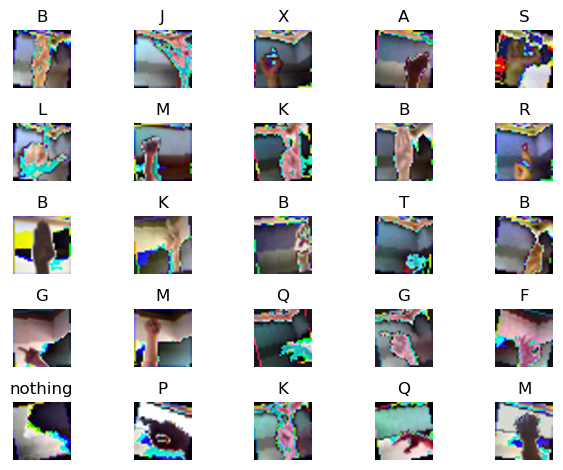

In [5]:
# load data to display
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("LeNetTransforms.png")

### Training and Accuracy Functions

Below are the functions we created for getting the accuracy of our model and to actually train the model. Let's walk through the inner mechanisms of each. 

The evaluate() function works by calculating how predictions are equal to the true label of the image for each batch, in other words how many did the model predict right. Then it simply divides this number by the amount of images are in the data set, multiplies it by a 100, and voila there is the model's accuracy.  Additionally this also gets the average loss function value per batch. We get the average since the train dataset has more batches and hence a cumulative function will produce artificially large loss values for the train data. Important note to use torch.no_grad() in order to make sure that none of our calculation interfere with gradient values later on.

The train model is slightly more complex, though it is nothing out of the ordinary. During the function runtime we unpack each batch into image pixels and labels, next we get the prediction of the current model and use those to calculate the loss. For the loss function we use CrossEntropyLoss which is standard for multi-class classification problems like we have here. After we get the loss we calculate the gradients with respect to each weight by calling loss.backward() and then perform an update rule via the optimizer class. 

In [6]:
def evaluate(model, test_loader, loss_criteria):
    """
    Tests the model's accuracy

    @params:
        model: pytorch nn.Module, model to evaluate
        test_loader: pytorch DataLoader, data to evaluate on
        loss_criteria: pytorch loss function, loss function

    @returns:
        (accuracy, test_loss) floats representing the percentage accuracy and average loss
    """
    
    # Sets model to eval mode
    model.eval()

    correct = 0
    test_loss = 0
    total_samples = 0
    
    with torch.no_grad():

        for data, label in test_loader:
            # Move data, label to device
            data = data.to(G_DEVICE)
            label = label.to(G_DEVICE)
            
            # Model's prediction
            output = model(data)
            
            # Calculate the number of correct responses in current batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(label==predicted).item()
            test_loss += loss_criteria(output, label).item()
            total_samples += data.size(0)
    
    # Get average loss
    test_loss = test_loss / total_samples
    # Get accuracy
    accuracy = round((100 * correct / len(test_loader.dataset)),2)
    
    return (accuracy, test_loss)

In [7]:
def train(model, train_loader, test_loader, optimizer, loss_criteria, epoch):
    """
    Trains the model parameters and returns average loss and percentage accuracy 
    
    @params:
        model - pytorch model to train
        train_loader - dataLoader object w/ training data
        test_loader - dataLoader object w/ testing data
        optimizer - pytorch optimizer object
        loss_criteria - pytorch loss criteria
        epoch - what the current epoch is
    
    @returns:
        (train_loss, test_loss, train_acc, test_acc) each a float 
    """
    
    # sets the model to training mode
    model.train()
    loss_tracker = 0
    correct = 0
    total_samples = 0
    
    # progress bar
    train_loader_iter = tqdm(train_loader, desc = f"Epoch {epoch + 1}")
    
    
    for data, label in train_loader_iter:

        data = data.to(G_DEVICE)
        label = label.to(G_DEVICE)

        # resets the gradients
        optimizer.zero_grad()
        
        # model's current prediction
        prediction = model(data)
        
        # tracks loss
        loss = loss_criteria(prediction, label)
        loss_tracker += loss.item()
        total_samples += data.size(0)
        
        # calculates gradient
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(prediction.data, 1)
        correct += torch.sum(label == predicted).item()
        
    # get training accuracy and average training loss
    train_acc = round((100 * correct / len(train_loader.dataset)), 2)
    train_loss =  loss_tracker / total_samples
    
    # get test accuracy and average loss
    test_acc, test_loss = evaluate(model, test_loader, loss_criteria)
        
    return (train_loss, test_loss, train_acc, test_acc)  

### Defining Parameters
Below we define our learning rate, epochs, and empty lists with loss and accuracy values. Additionally we initialize the model, optimizer, and the loss function.

Through trial and error of using a subset dataset we found that the more or less default learning rate of 0.01 was actually optimal for our training. Any larger values produced gradient steps that were too large and the model would overstep the global minimum. Additionally we chose the Adam optimizer since it helps use momentum to optimize the weights quicker, something we value greatly since our resources are limited and training models for a long time is quite constraining. 

In [8]:
learning_rate = 0.001
epochs = 30
lenet_train_losses = []; lenet_test_losses = []; 
lenet_train_accuracies = []; lenet_test_accuracies = []

# Perform workflow with LeNet
lenet = LeNet5().to(G_DEVICE)
optimizer = optim.Adam(lenet.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)

### Training the Model
This code simply calls the train function epoch amount of times and appends the accuracies and loss values. 

In [9]:
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(lenet, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    lenet_train_losses.append(train_loss)
    lenet_test_losses.append(test_loss)
    lenet_train_accuracies.append(train_accuracy)
    lenet_test_accuracies.append(test_accuracy)

Epoch 30: 100%|██████████| 544/544 [00:04<00:00, 112.49it/s]


In [10]:
def make_plots(file_name, train_losses, test_losses, train_accuracies, test_accuracies):
    """
    Creates a losses and accuracies plots and saves them to specified file name.

    @params:
        file_name: string, name with which to save plot 
        train_losses: list of floats
        test_losses: list of floats
        train_accuracies: list of floats
        test_accuracies: list of floats
    """
    # create subplots
    fig, ax = plt.subplots(1, 2, figsize = (20, 8))
    
    # plot the losses
    ax[0].plot(np.arange(1, epochs + 1), train_losses, label = "Train Loss")
    ax[0].plot(np.arange(1, epochs + 1), test_losses, label = "Test Loss")
    ax[0].set(title = "Losses over Epochs", ylabel = "Loss", xlabel = "Epoch")
    ax[0].set_xticks(np.arange(1, epochs + 1, 3));
    ax[0].legend(loc = "upper right")

    # plot the accuracies
    ax[1].plot(np.arange(1,epochs + 1), train_accuracies, label = "Train Accuracy")
    ax[1].plot(np.arange(1,epochs + 1), test_accuracies, label = "Test Accuracy")
    ax[1].set(title = "Accuracies over Epochs", ylabel = "Accuracy %", xlabel = "Epoch")
    ax[1].set_xticks(np.arange(1, epochs + 1, 3));
    ax[1].legend(loc = "upper right")

    # save plot
    plt.savefig(file_name, format="png")

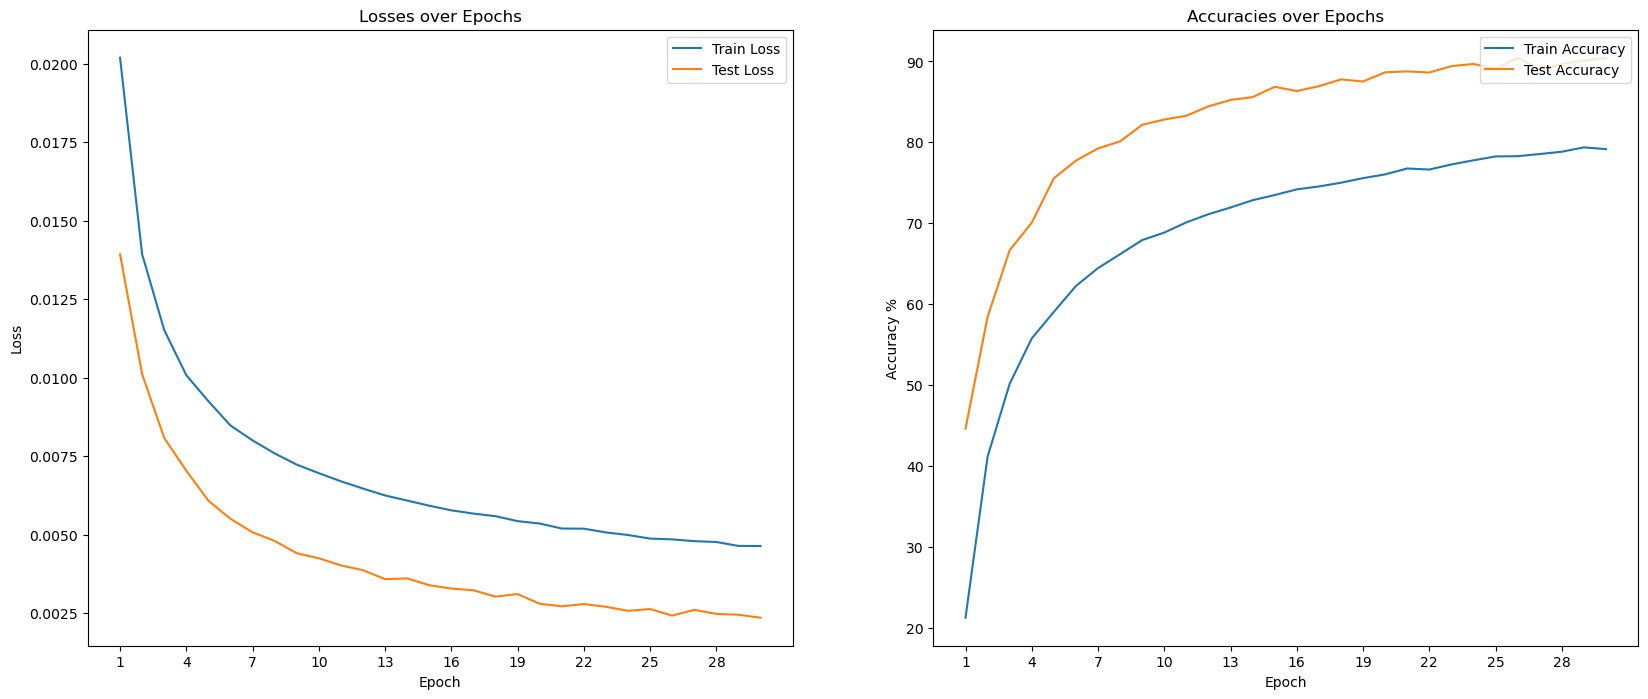

In [11]:
# save and show the plot for LeNet
make_plots("LeNet30EpochHistory.png", lenet_train_losses, lenet_test_losses, lenet_train_accuracies, lenet_test_accuracies)

The code below is for testing purposes rn. Also currently the validation set is more or less used as a test so maybe we abolish the test_loader all together...

In [12]:
# save the LeNet model weights
save_model(lenet, "LeNet30Epoch.pth")

In [13]:
lenet_accuracy, lenet_loss = evaluate(lenet, test_loader = test_loader, loss_criteria = loss_criteria)
print(f"LENET ACCURACY {lenet_accuracy} LOSS {lenet_loss}")

LENET ACCURACY 90.19 LOSS 0.00237689483672067


In [14]:
def create_confusion_matrix(file_name, model, test_loader):
    """ 
    Creates a confusion matrix given a model and a dataLoader object
    
    @params:
        model: pytorch nn.Module, model for which the matrix is made
        test_loader: pytorch dataloader, data with which the matrix is made
    """
    
    # sets the model to eval mode
    model.eval()

    labels_list = []
    predicted_list = []
    
    with torch.no_grad():
    
        for data, label in test_loader:
            # fills the labels and predictions
            labels_list.extend(label.numpy())
            # convert to device to calculate
            data = data.to(G_DEVICE)
            label = label.to(G_DEVICE)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            # convert back to cpu to do numpy
            predicted_list.extend(predicted.cpu().numpy())
            
    # construct the confusion matrix 
    conf_matrix = confusion_matrix(labels_list, predicted_list)
    
    # creates a sns heatmap with the conf matrix
    plt.figure(figsize=(14,10))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=labels_names, yticklabels=labels_names, vmax = 100)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # saves the figure
    plt.savefig(file_name)

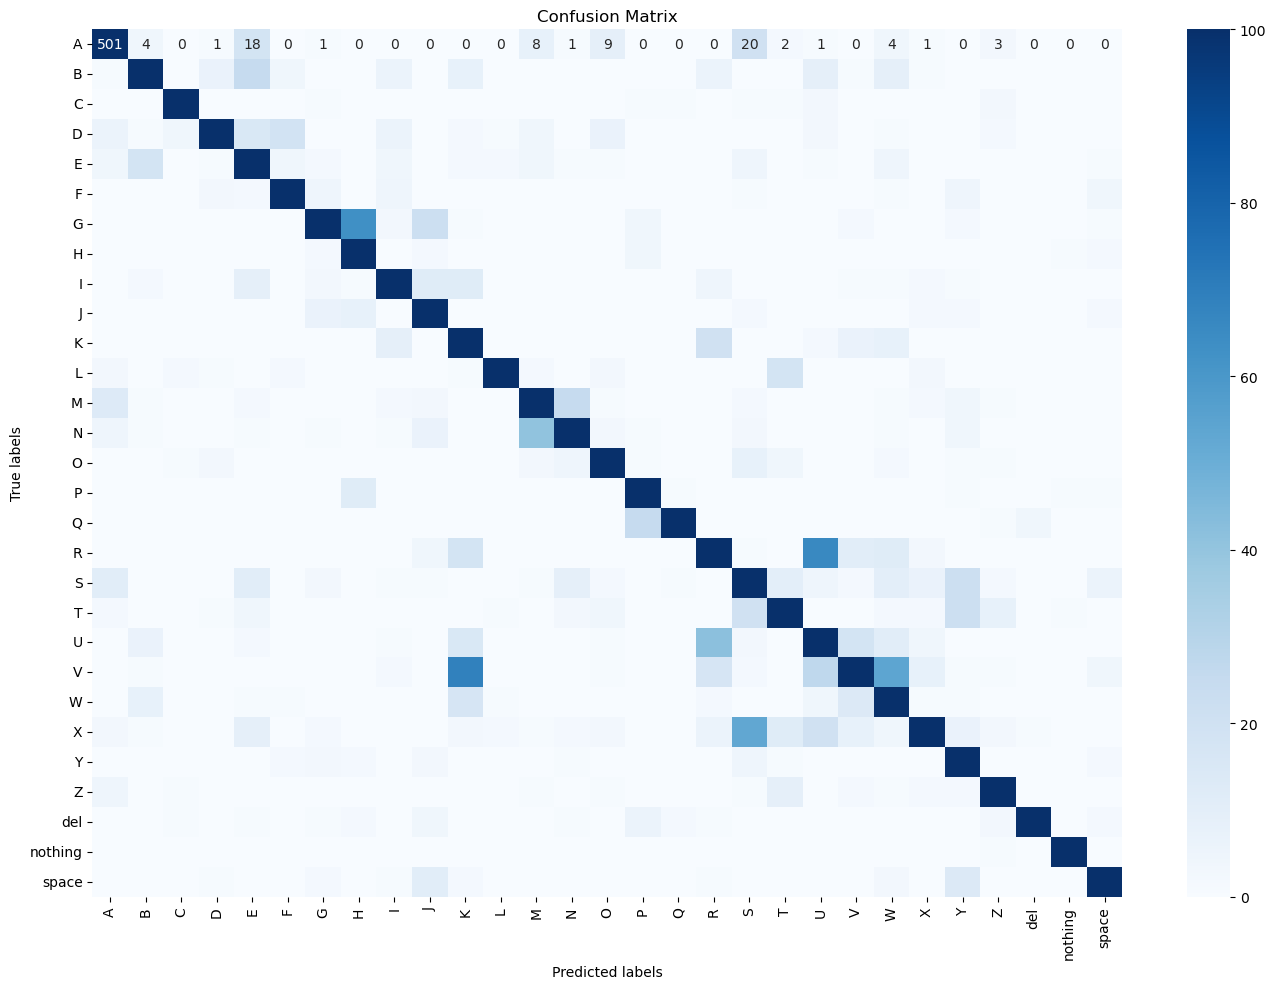

<Figure size 640x480 with 0 Axes>

In [15]:
# confusion matrix for LeNet
create_confusion_matrix("LeNet30EpochConfusion.png", lenet, test_loader)

In [16]:
# delete LeNet Model
del lenet

In [17]:
# load data for AlexNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_alex)

/home/karl/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


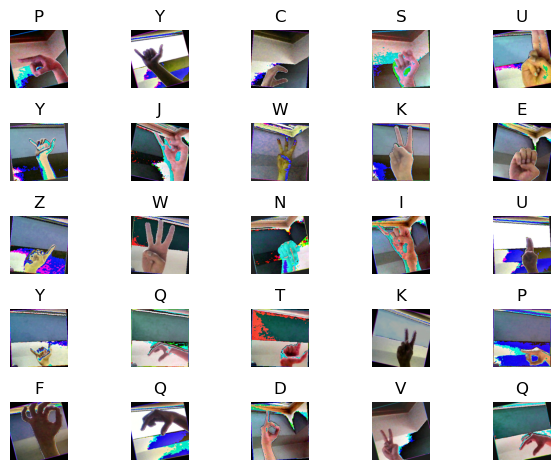

In [18]:
# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("AlexNetTransforms.png")

In [20]:
learning_rate = 0.001
epochs = 30
alex_train_losses = []; alex_test_losses = []; 
alex_train_accuracies = []; alex_test_accuracies = []

# Perform workflow with AlexNet
alex = AlexNet().to(G_DEVICE)
optimizer = optim.Adam(alex.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)

In [22]:
# train AlexNet
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(alex, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    alex_train_losses.append(train_loss)
    alex_test_losses.append(test_loss)
    alex_train_accuracies.append(train_accuracy)
    alex_test_accuracies.append(test_accuracy)

Epoch 1: 100%|██████████| 680/680 [00:44<00:00, 15.24it/s]


ZeroDivisionError: division by zero

In [ ]:
# save and show the plot for AlexNet
make_plots("AlexNet30EpochHistory.png", alex_train_losses, alex_test_losses, alex_train_accuracies, alex_test_accuracies)

In [ ]:
# save the AlexNet model weights
save_model(alex, "AlexNet30Epoch.pth")

In [ ]:
alex_accuracy, alex_loss = evaluate(alex, test_loader = test_loader, loss_criteria = loss_criteria)
print(f"ALEX ACCURACY {alex_accuracy} LOSS {alex_loss}")

In [ ]:
# confusion matrix for AlexNet
create_confusion_matrix("AlexNet30EpochConfusion.png", alex, test_loader)

In [ ]:
# delete AlexNet Model
del alex